In [1]:
!pip install medmnist
!pip install torcheval

In [120]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objs as go
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, mean_squared_error
import torch
import numpy as np
import torchvision
import gc
import tqdm
from torchinfo import summary
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torchmetrics.classification import MulticlassAccuracy, MulticlassROC, MulticlassConfusionMatrix
import matplotlib.pyplot as plt
import torch.optim as lr_scheduler
import torch.backends.cudnn as cudnn 
from torch.optim.lr_scheduler import StepLR
import gc
cudnn.benchmark = True
plt.ion() 
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve
import torch.utils.data as data
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, recall_score,precision_score,f1_score,confusion_matrix,precision_recall_fscore_support

In [3]:
import medmnist
from medmnist import INFO, Evaluator, OCTMNIST

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


**OCTMNIST 2D dataset** - Multiclass classification

In [73]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [6]:
folder_path = 'octmnist'
BATCH_SIZE = 256
lr = 0.001
info = INFO[folder_path]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [7]:
print(f"The no of channels in the {folder_path} dataset are : {n_channels}")
print(f"The no of classes in the {folder_path} dataset are : {n_classes}")

The no of channels in the octmnist dataset are : 1
The no of classes in the octmnist dataset are : 4


In [8]:
print(f"The task of {folder_path} is to perform {task} classification")
print(f"The info of {folder_path} : {info}")

The task of octmnist is to perform multi-class classification
The info of octmnist : {'python_class': 'OCTMNIST', 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1', 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842', 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1', 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf', 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1', 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',

In [9]:
folder_path=info['python_class']
folder_path

'OCTMNIST'

In [10]:
DataClass = getattr(medmnist, info['python_class'])
DataClass

medmnist.dataset.OCTMNIST

In [11]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
])

dataset = DataClass(split='train', transform=preprocess, download=True)

Using downloaded and verified file: /Users/radhikasingh/.medmnist/octmnist.npz


In [12]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

size = len(dataset)
train_size = int(size*0.7)
val_size = int(0.5*(size-train_size))
test_size = int(size-(train_size+val_size))

print(size,train_size,val_size,test_size)

97477 68233 14622 14622


In [13]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [14]:
test_dataset,train_dataset,val_dataset

(<torch.utils.data.dataset.Subset at 0x17782d990>,
 <torch.utils.data.dataset.Subset at 0x1778171d0>)

In [66]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

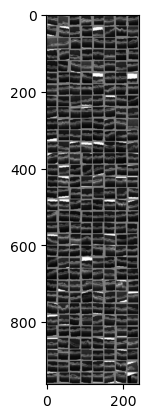

In [16]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [17]:
dataset.montage(length=1)

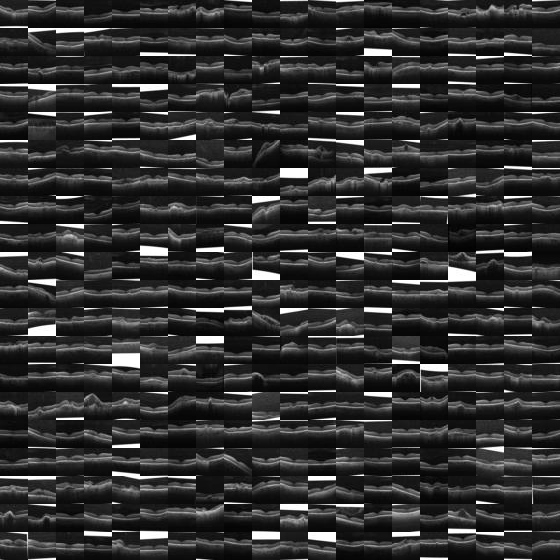

In [18]:
dataset.montage(length=20)

In [19]:
for x, y in train_loader:
    print(f"The size of the train dataset : {x.shape} , {y.shape}")
    break

The size of the train dataset : torch.Size([256, 1, 28, 28]) , torch.Size([256, 1])


In [20]:
for x, y in val_loader:
    print(f"The size of the val dataset : {x.shape} , {y.shape}")
    break

The size of the val dataset : torch.Size([256, 1, 28, 28]) , torch.Size([256, 1])


In [21]:
for x, y in test_loader:
    print(f"The size of the test dataset : {x.shape} , {y.shape}")
    break

The size of the test dataset : torch.Size([256, 1, 28, 28]) , torch.Size([256, 1])


In [22]:
num_epochs =5

# Model 1

In [23]:
class OCTMNIST_Net_One(nn.Module):
    def __init__(self, ch, cl):
        super(OCTMNIST_Net_One, self).__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(ch, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.l2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64))
        
        self.l4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64))

        self.l5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4*4, 400),  
            nn.ReLU(),
            nn.Linear(400, 256))
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.ReLU())
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, cl))

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

octmnist_model_one = OCTMNIST_Net_One(n_channels, n_classes)
criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(octmnist_model_one.parameters(), lr=lr,momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [24]:
octmnist_model_one

OCTMNIST_Net_One(
  (l1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [25]:
octmnist_model_one = octmnist_model_one.to(device)
summary(octmnist_model_one)

Layer (type:depth-idx)                   Param #
OCTMNIST_Net_One                         --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-8                       18,496
│    └─BatchNorm2d: 2-9                  128
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      36,928
│    └─BatchNorm2d: 2-11                 128
├─Sequential: 1-5                        --
│    └─Conv2d: 2-12                      36,928
│    └─BatchNorm2d: 2-13                 128
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
├─Sequen

In [26]:
octmnist_time_one,octmnist_train_acc_one,octmnist_val_acc_one,octmnist_test_acc_one,octmnist_train_loss_one,octmnist_test_loss_one,octmnist_val_loss_one,octmnist_y_pred_test_one,octmnist_y_labels_test_one=[],[],[],[],[],[],[],[],[]
num_epochs = 5
start_time=time.time()
metric = MulticlassAccuracy(average=None, num_classes=n_classes)

for epoch in range(num_epochs):
    octmnist_model_one.train()
    running_loss, correct, total = 0.0, 0, 0
    train_preds, train_targets = torch.tensor([]), torch.tensor([])
    for batch in train_loader:
        features, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = octmnist_model_one(features)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_accuracy = (correct/total)
    octmnist_train_acc_one.append(train_accuracy)
    octmnist_train_loss_one.append(running_loss/ len(train_loader))
    print(f"Epoch {epoch + 1},Train Loss: {running_loss/ len(train_loader)}, Accuracy: {train_accuracy}%")
    
    scheduler.step()
    
    octmnist_model_one.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds, val_targets = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_one(features)
            loss = criterion(outputs, labels.view(-1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct/total)
    octmnist_val_acc_one.append(val_accuracy)
    octmnist_val_loss_one.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}%")
    
    
    octmnist_model_one.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_one(features)
            loss = criterion(outputs, labels.view(-1))
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            octmnist_y_pred_test_one.append(predicted)
            octmnist_y_labels_test_one.append(labels)
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct/total)
    octmnist_test_acc_one.append(test_accuracy)
    octmnist_test_loss_one.append(running_loss)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy}%")

end_time=time.time()
octmnist_time_one=end_time-start_time

Epoch 1,Train Loss: 1.2771840738446525, Accuracy: 83.64917268770243%
Validation Loss: 1.1613396180087123, Accuracy: 83.94950214229678%
Test Loss: 1.155386375969854, Accuracy: 84.34023410650718%
Epoch 2,Train Loss: 1.0546876017966966, Accuracy: 78.47406680052174%
Validation Loss: 1.007621520552142, Accuracy: 78.16353871220808%
Test Loss: 1.001310976414845, Accuracy: 78.12361890497246%
Epoch 3,Train Loss: 0.9954545017931792, Accuracy: 77.555742822388%
Validation Loss: 0.9933976140515558, Accuracy: 77.22930420614327%
Test Loss: 0.987050743966267, Accuracy: 77.16526975594243%
Epoch 4,Train Loss: 0.9837177802114451, Accuracy: 77.52473143493617%
Validation Loss: 0.9827184790167315, Accuracy: 77.25793253273791%
Test Loss: 0.977474701815638, Accuracy: 77.23552222575582%
Epoch 5,Train Loss: 0.978294419215413, Accuracy: 77.4648923541395%
Validation Loss: 1.0156801240197544, Accuracy: 76.62990767002594%
Test Loss: 1.0054641540708213, Accuracy: 76.22020579213559%


In [93]:
# metric = MulticlassConfusionMatrix(num_classes=n_classes)
# metric(torch.tensor(octmnist_y_pred_test_one), torch.tensor(octmnist_y_labels_test_one))
y_pred_test_tensor = torch.cat(octmnist_y_pred_test_one)
y_labels_test_tensor = torch.cat(octmnist_y_labels_test_one)
y_pred_test = y_pred_test_tensor.cpu().numpy()
y_labels_test = y_labels_test_tensor.cpu().numpy()
precision = precision_score(y_labels_test, y_pred_test, average='macro')
recall = recall_score(y_labels_test, y_pred_test, average='macro')
f1 = f1_score(y_labels_test, y_pred_test, average='macro')
print(f'Precision of Octmnist2d model 1 : {precision}')
print(f'Recall of Octmnist2d model 1 : {recall}')
print(f'F1-score of Octmnist2d model 1 : {f1}')

Precision of Octmnist2d model 1 : 0.3598374376745806
Recall of Octmnist2d model 1 : 0.4356260784916576
F1-score of Octmnist2d model 1 : 0.39379028503769953


/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
y_pred_test_array = np.concatenate([p.cpu().numpy() for p in octmnist_y_pred_test_one])
y_labels_test_array = np.concatenate([l.cpu().numpy() for l in octmnist_y_labels_test_one])
matrix = confusion_matrix(y_labels_test_array, y_pred_test_array)
print(f'Confusion Matrix of OCTMNSIT2D Model 1 : {matrix}')

Confusion Matrix of OCTMNSIT2D Model 1 : [[20618     0     0  4432]
 [ 3542     0     0  4013]
 [ 1605     0     0  4135]
 [ 2801     0     0 31964]]


<Axes: >

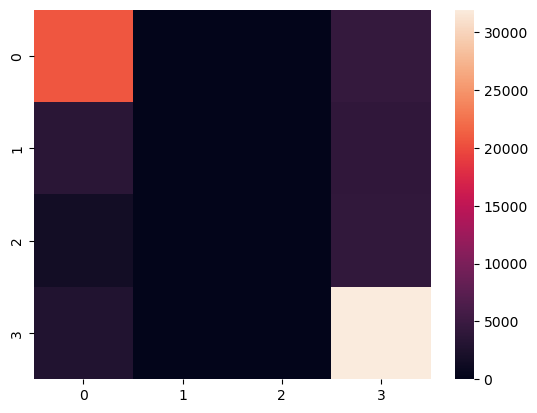

In [122]:
import seaborn as sns
sns.heatmap(matrix)

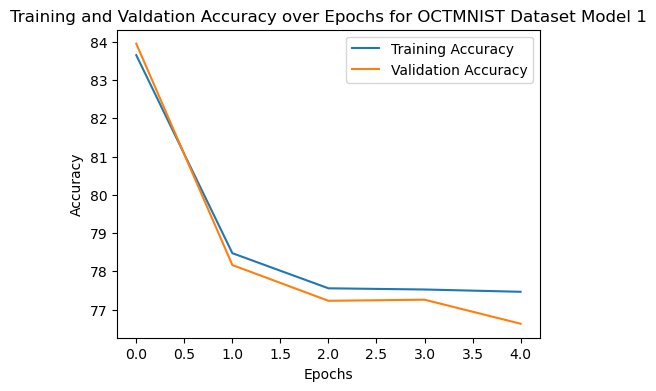

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_acc_one, label='Training Accuracy')
plt.plot(octmnist_val_acc_one, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdation Accuracy over Epochs for OCTMNIST Dataset Model 1')
plt.legend()
plt.show()

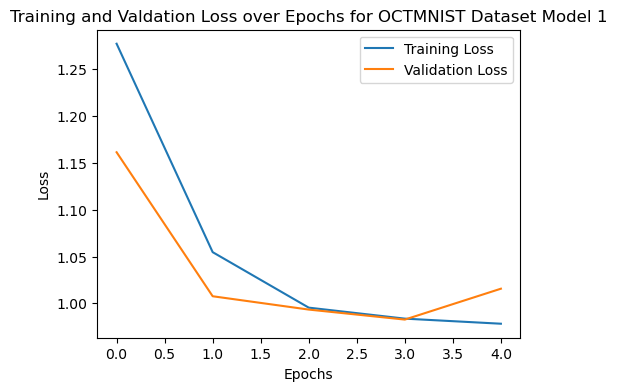

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_loss_one, label='Training Loss')
plt.plot(octmnist_val_loss_one, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Valdation Loss over Epochs for OCTMNIST Dataset Model 1')
plt.legend()
plt.show()

# Model 2 - Dropout of 0.2 before every layer

In [100]:
class OCTMNIST_Net_Two(nn.Module):
    def __init__(self, channels, classes):
        super(OCTMNIST_Net_Two, self).__init__()
        
        self.dropout = nn.Dropout(0.2)
        
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3),
            nn.BatchNorm2d(32))
        
        self.dropout = nn.Dropout(0.2)
        
        self.l2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.dropout = nn.Dropout(0.2)
        
        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64))
        
        self.dropout = nn.Dropout(0.2)
        
        self.l4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64))
        
        self.dropout = nn.Dropout(0.2)
        
        self.l5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200,256))
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, classes))
#no change in the accuracy
#         self.fc3 = nn.Sequential(
#             nn.Linear(60, 30),
#             nn.ReLU(),
#             nn.Linear(10, classes))
        
#         self.fc4 = nn.Sequential(
#             nn.Linear(30, 10),
#             nn.ReLU(),
#             nn.Linear(10, classes))

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        #x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x


octmnist_model_two = OCTMNIST_Net_Two(channels=n_channels, classes=n_classes)
criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(octmnist_model_two.parameters(), lr=lr,momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [101]:
octmnist_model_two

OCTMNIST_Net_Two(
  (dropout): Dropout(p=0.2, inplace=False)
  (l1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momen

In [102]:
octmnist_model_two = octmnist_model_two.to(device)
summary(octmnist_model_two)

Layer (type:depth-idx)                   Param #
OCTMNIST_Net_Two                         --
├─Dropout: 1-1                           --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
├─Sequential: 1-3                        --
│    └─Conv2d: 2-3                       9,248
│    └─BatchNorm2d: 2-4                  64
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-7                       18,496
│    └─BatchNorm2d: 2-8                  128
├─Sequential: 1-5                        --
│    └─Conv2d: 2-9                       36,928
│    └─BatchNorm2d: 2-10                 128
├─Sequential: 1-6                        --
│    └─Conv2d: 2-11                      36,928
│    └─ReLU: 2-12                        --
│    └─BatchNorm2d: 2-13                 128
│    └─MaxPool2d: 2-14                   --
├─Sequen

In [103]:
octmnist_time_two,octmnist_train_acc_two,octmnist_val_acc_two,octmnist_test_acc_two,octmnist_train_loss_two,octmnist_test_loss_two,octmnist_val_loss_two,octmnist_y_pred_test_two,octmnist_y_labels_test_two=[],[],[],[],[],[],[],[],[]
num_epochs = 5
start_time=time.time()
metric = MulticlassAccuracy(average=None, num_classes=n_classes)

for epoch in range(num_epochs):
    octmnist_model_two.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch in train_loader:
        features, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = octmnist_model_two(features)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_accuracy = (correct/total)
    octmnist_train_acc_two.append(train_accuracy)
    octmnist_train_loss_two.append(running_loss/ len(train_loader))
    print(f"Epoch {epoch + 1},Train Loss: {running_loss/ len(train_loader)}, Accuracy: {train_accuracy}%")
    
    scheduler.step()
    
    octmnist_model_two.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds, val_targets = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_two(features)
            loss = criterion(outputs, labels.view(-1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct/total)
    octmnist_val_acc_two.append(val_accuracy)
    octmnist_val_loss_two.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}%")
    
    
    octmnist_model_two.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_two(features)
            loss = criterion(outputs, labels.view(-1))
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            octmnist_y_pred_test_two.append(predicted)
            octmnist_y_labels_test_two.append(labels)
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct/total)
    octmnist_test_acc_two.append(test_accuracy)
    octmnist_test_loss_two.append(running_loss)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy}%")

end_time=time.time()
octmnist_time_two=end_time-start_time

Epoch 1,Train Loss: 1.3237359885419353, Accuracy: 88.34286928612255%
Validation Loss: 1.2301193496276592, Accuracy: 88.63509745941705%
Test Loss: 1.224867319238597, Accuracy: 89.06257886475784%
Epoch 2,Train Loss: 1.1843854345185927, Accuracy: 89.0464144915217%
Validation Loss: 1.1327442465157345, Accuracy: 87.71101321585903%
Test Loss: 1.1264854135184452, Accuracy: 86.93334837961775%
Epoch 3,Train Loss: 1.0443820055950894, Accuracy: 78.23355267978837%
Validation Loss: 1.010159347591729, Accuracy: 78.195329189548%
Test Loss: 1.0050055281869297, Accuracy: 78.35561209310914%
Epoch 4,Train Loss: 0.9957910407794995, Accuracy: 77.60922134451071%
Validation Loss: 0.993505938299771, Accuracy: 77.71171323396295%
Test Loss: 0.9904265259874279, Accuracy: 77.9786718918309%
Epoch 5,Train Loss: 0.9846130192056577, Accuracy: 77.48351970454179%
Validation Loss: 0.9980699317208652, Accuracy: 77.73457244583912%
Test Loss: 0.995016755728886, Accuracy: 78.08786688141818%


In [104]:
# metric = MulticlassConfusionMatrix(num_classes=n_classes)
# metric(octmnist_y_pred_test_two, octmnist_y_target_test_two)
y_pred_test_tensor = torch.cat(octmnist_y_pred_test_two)
y_labels_test_tensor = torch.cat(octmnist_y_labels_test_two)
y_pred_test = y_pred_test_tensor.cpu().numpy()
y_labels_test = y_labels_test_tensor.cpu().numpy()
precision = precision_score(y_labels_test, y_pred_test, average='macro')
recall = recall_score(y_labels_test, y_pred_test, average='macro')
f1 = f1_score(y_labels_test, y_pred_test, average='macro')
print(f'Precision of Octmnist2d model 2 : {precision}')
print(f'Recall of Octmnist2d model 2 : {recall}')
print(f'F1-score of Octmnist2d model 2 : {f1}')

Precision of Octmnist2d model 2 : 0.3587530594646008
Recall of Octmnist2d model 2 : 0.40085793607664577
F1-score of Octmnist2d model 2 : 0.3684429263088712


/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
y_pred_test = np.concatenate([p.cpu().numpy() for p in octmnist_y_pred_test_two])
y_labels_test = np.concatenate([l.cpu().numpy() for l in octmnist_y_labels_test_two])
matrix = confusion_matrix(y_labels_test, y_pred_test)
print(f'Confusion Matrix of OCTMNSIT2D Model 2 : {matrix}')

Confusion Matrix of OCTMNSIT2D Model 2 : [[15892     0     0  9158]
 [ 2126     0     0  5429]
 [  689     0     0  5051]
 [ 1077     0     0 33688]]


<Axes: >

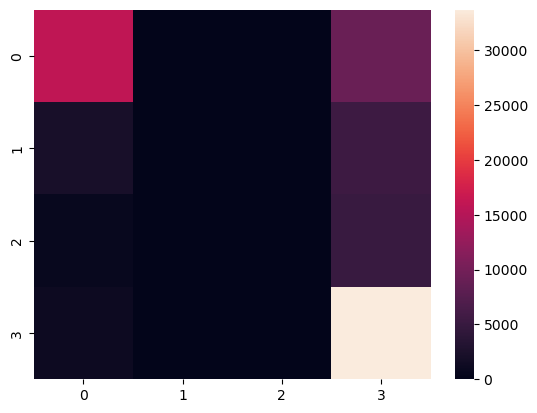

In [125]:
sns.heatmap(matrix)

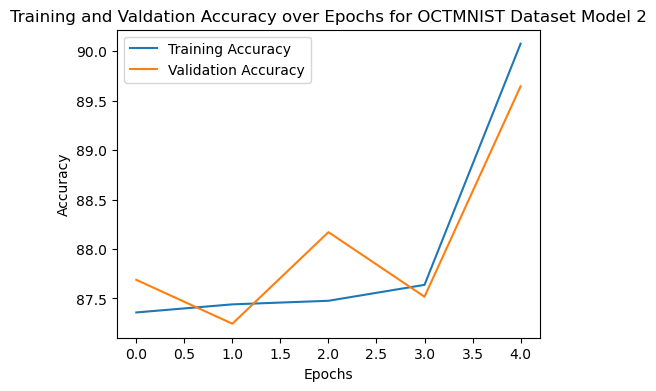

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_acc_two, label='Training Accuracy')
plt.plot(octmnist_val_acc_two, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Valdation Accuracy over Epochs for OCTMNIST Dataset Model 2')
plt.legend()
plt.show()

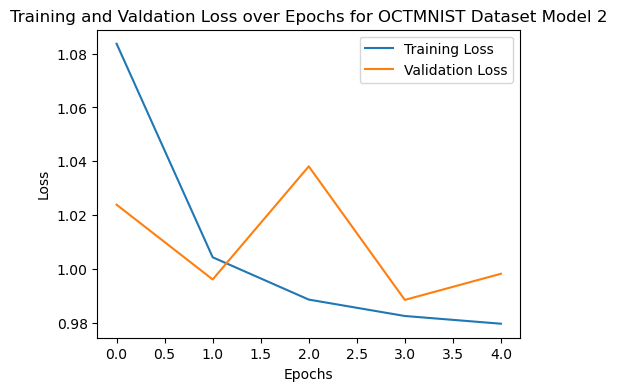

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_loss_two, label='Training Loss')
plt.plot(octmnist_val_loss_two, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Valdation Loss over Epochs for OCTMNIST Dataset Model 2')
plt.legend()
plt.show()

In [131]:
torch.save(octmnist_model_two.state_dict(), './rsingh57_assignment0_part3')

# Model 3 - Early Stopping

In [110]:
class OCTMNIST_Net_Three(nn.Module):
    def __init__(self, channels, classes):
        super(OCTMNIST_Net_Three, self).__init__()
        
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3),
            nn.BatchNorm2d(32))
        
        self.l2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64))
        
        self.l4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64))
        
        self.l5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200,256))
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, classes))

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1) #cross entropy loss contains softmax implementation
        return x


octmnist_model_three = OCTMNIST_Net_Three(channels=n_channels, classes=n_classes)
criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(octmnist_model_three.parameters(), lr=lr,momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [111]:
octmnist_model_three

OCTMNIST_Net_Three(
  (l1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

In [112]:
octmnist_model_three = octmnist_model_three.to(device)
summary(octmnist_model_three)

Layer (type:depth-idx)                   Param #
OCTMNIST_Net_Three                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
├─Sequential: 1-2                        --
│    └─Conv2d: 2-3                       9,248
│    └─BatchNorm2d: 2-4                  64
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       18,496
│    └─BatchNorm2d: 2-8                  128
├─Sequential: 1-4                        --
│    └─Conv2d: 2-9                       36,928
│    └─BatchNorm2d: 2-10                 128
├─Sequential: 1-5                        --
│    └─Conv2d: 2-11                      36,928
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-6                        --
│    └─L

In [113]:
octmnist_time_three,octmnist_train_acc_three,octmnist_val_acc_three,octmnist_test_acc_three,octmnist_train_loss_three,octmnist_test_loss_three,octmnist_val_loss_three,octmnist_y_pred_test_three,octmnist_y_labels_test_three=[],[],[],[],[],[],[],[],[]
num_epochs = 20
start_time=time.time()
metric = MulticlassAccuracy(average=None, num_classes=n_classes)
patience = 2 
best_val_loss = np.Inf
counter = 0
max_stagnation = 5 
best_val_loss, best_val_epoch = None, None

for epoch in range(num_epochs):
    octmnist_model_three.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch in train_loader:
        features, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = octmnist_model_three(features)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_accuracy = (correct/total)
    octmnist_train_acc_three.append(train_accuracy)
    octmnist_train_loss_three.append(running_loss/ len(train_loader))
    print(f"Epoch {epoch + 1},Train Loss: {running_loss/ len(train_loader)}, Accuracy: {train_accuracy}%")
    
    scheduler.step()
    
    octmnist_model_three.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds, val_targets = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_three(features)
            loss = criterion(outputs, labels.view(-1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct/total)
    octmnist_val_acc_three.append(val_accuracy)
    octmnist_val_loss_three.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}%")
    if best_val_loss is None or best_val_loss < val_loss:
        best_val_loss, best_val_epoch = val_loss, epoch
    if best_val_epoch < epoch - max_stagnation:
        early_stop = True
        print(f"Early stopping happened at epoch {epoch}")
        break  
    
    
    octmnist_model_three.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_three(features)
            loss = criterion(outputs, labels.view(-1))
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            octmnist_y_pred_test_three.append(predicted)
            octmnist_y_labels_test_three.append(labels)
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct/total)
    octmnist_test_acc_three.append(test_accuracy)
    octmnist_test_loss_three.append(running_loss)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy}%")

end_time=time.time()
octmnist_time_three=end_time-start_time

Epoch 1,Train Loss: 1.1967580894405923, Accuracy: 88.07814400656574%
Validation Loss: 1.10712576631842, Accuracy: 89.2976404562187%
Test Loss: 1.0937672874023174, Accuracy: 90.36587092339731%
Epoch 2,Train Loss: 0.9098850026559294, Accuracy: 85.89209033751997%
Validation Loss: 0.7895155620986017, Accuracy: 84.76335767304327%
Test Loss: 0.7795153547977579, Accuracy: 84.1432645649743%
Epoch 3,Train Loss: 0.7134411625201336, Accuracy: 82.67231398297012%
Validation Loss: 0.6956190168857574, Accuracy: 82.60668637982016%
Test Loss: 0.6776351363494478, Accuracy: 82.71499943576434%
Epoch 4,Train Loss: 0.6602245220977269, Accuracy: 82.4773350138496%
Validation Loss: 0.7316716303085459, Accuracy: 81.95582644378734%
Test Loss: 0.6977508643577839, Accuracy: 81.76638591667778%
Epoch 5,Train Loss: 0.6299576157710972, Accuracy: 82.3595327773951%
Validation Loss: 0.7663327506903944, Accuracy: 81.63840444149417%
Test Loss: 0.7506890183892744, Accuracy: 81.27185900263652%
Epoch 6,Train Loss: 0.607547852

In [114]:
y_pred_test_tensor = torch.cat(octmnist_y_pred_test_three)
y_labels_test_tensor = torch.cat(octmnist_y_labels_test_three)
y_pred_test_array = y_pred_test_tensor.cpu().numpy()
y_labels_test_array = y_labels_test_tensor.cpu().numpy()
precision = precision_score(y_labels_test_array, y_pred_test_array, average='macro')
recall = recall_score(y_labels_test_array, y_pred_test_array, average='macro')
f1 = f1_score(y_labels_test_array, y_pred_test_array, average='macro')
print(f'Precision of Octmnist2d model 3 : {precision}')
print(f'Recall of Octmnist2d model 3 : {recall}')
print(f'F1-score of Octmnist2d model 3 : {f1}')

Precision of Octmnist2d model 3 : 0.5380191111702388
Recall of Octmnist2d model 3 : 0.42888507652298613
F1-score of Octmnist2d model 3 : 0.3918405369392794


/Users/radhikasingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


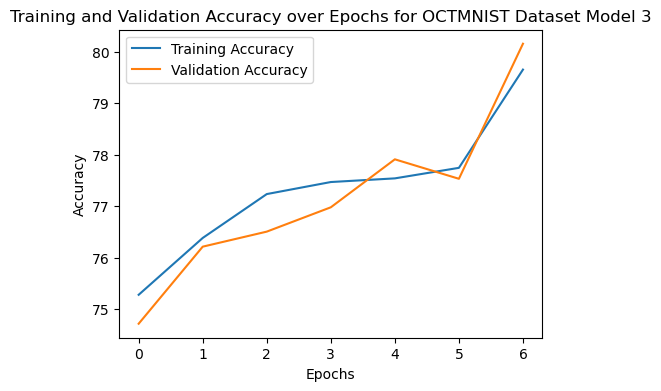

In [90]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_acc_three, label='Training Accuracy')
plt.plot(octmnist_val_acc_three, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs for OCTMNIST Dataset Model 3')
plt.legend()
plt.show()

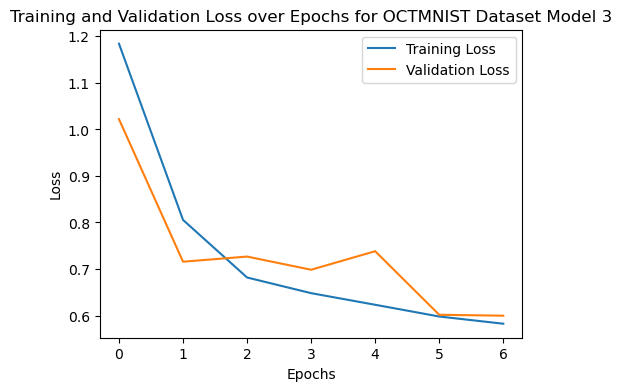

In [91]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_loss_three, label='Training Loss')
plt.plot(octmnist_val_loss_three, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for OCTMNIST Dataset Model 3')
plt.legend()
plt.show()

In [126]:
y_pred_test = np.concatenate([p.cpu().numpy() for p in octmnist_y_pred_test_three])
y_labels_test = np.concatenate([l.cpu().numpy() for l in octmnist_y_labels_test_three])
matrix = confusion_matrix(y_labels_test, y_pred_test)
print(f'Confusion Matrix of OCTMNSIT2D Model 3 : {matrix}')

Confusion Matrix of OCTMNSIT2D Model 3 : [[23412    17     0  6631]
 [ 4300   105     0  4661]
 [ 2022     6     0  4860]
 [ 3109    15     0 38594]]


<Axes: >

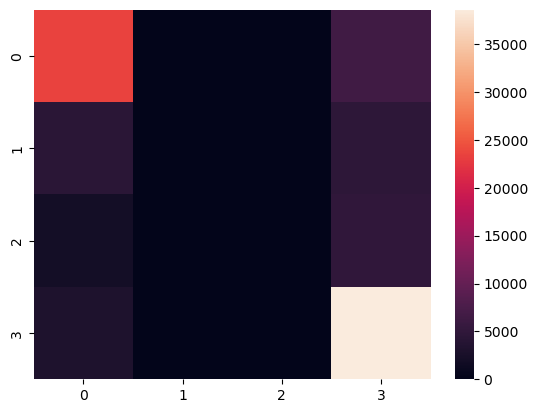

In [127]:
sns.heatmap(matrix)

# Regularization - L1 

In [115]:
class OCTMNIST_Net_Four(nn.Module):
    def __init__(self, channels, classes):
        super(OCTMNIST_Net_Four, self).__init__()
        
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.l2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.l3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.l4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.l5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200,256))
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, classes))

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x


octmnist_model_four = OCTMNIST_Net_Four(channels=n_channels, classes=n_classes)
criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(octmnist_model_four.parameters(), lr=lr,momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [116]:
octmnist_model_four

OCTMNIST_Net_Four(
  (l1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [117]:
octmnist_model_four = octmnist_model_four.to(device)
summary(octmnist_model_four)

Layer (type:depth-idx)                   Param #
OCTMNIST_Net_Four                        --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-8                       18,496
│    └─BatchNorm2d: 2-9                  128
│    └─ReLU: 2-10                        --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-11                      36,928
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-14                      36,928
│    └─BatchNorm2d: 2-15                 128
│    └─R

In [118]:
octmnist_time_four,octmnist_train_acc_four,octmnist_val_acc_four,octmnist_test_acc_four,octmnist_train_loss_four,octmnist_test_loss_four,octmnist_val_loss_four,octmnist_y_pred_test_four,octmnist_y_labels_test_four=[],[],[],[],[],[],[],[],[]
num_epochs = 20
start_time=time.time()
metric = MulticlassAccuracy(average=None, num_classes=n_classes)

for epoch in range(num_epochs):
    octmnist_model_four.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch in train_loader:
        features, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = octmnist_model_four(features)
        loss = criterion(outputs, labels.view(-1))
        l1_lambda , l1_params = 0.01 , torch.tensor(0., requires_grad=True)
        for model_param in octmnist_model_four.parameters():
            l1_params = l1_params + torch.sum(torch.abs(model_param))
        
        loss = loss.item() + l1_lambda * l1_params
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        del features, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_accuracy = (correct/total)
    octmnist_train_acc_four.append(train_accuracy)
    octmnist_train_loss_four.append(running_loss/ len(train_loader))
    print(f"Epoch {epoch + 1},Train Loss: {running_loss/ len(train_loader)}, Accuracy: {train_accuracy}%")
    
    scheduler.step()
    
    octmnist_model_four.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds, val_targets = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_four(features)
            loss = criterion(outputs, labels.view(-1))
            l1_lambda , l1_params = 0.01 , torch.tensor(0., requires_grad=True)
            for model_param in octmnist_model_four.parameters():
                l1_params = l1_params + torch.sum(torch.abs(model_param))
            val_loss+= loss.item() + l1_lambda * l1_params
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_val_loss = val_loss.item() / len(val_loader)
    val_accuracy = (correct/total)
    octmnist_val_acc_four.append(val_accuracy)
    octmnist_val_loss_four.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}%")
    
    
    octmnist_model_four.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = octmnist_model_four(features)
            loss = criterion(outputs, labels.view(-1))
            l1_lambda , l1_params = 0.01 , torch.tensor(0., requires_grad=True)
            for model_param in octmnist_model_four.parameters():
                l1_params = l1_params + torch.sum(torch.abs(model_param))
            test_loss+= loss.item() + l1_lambda * l1_params
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            octmnist_y_pred_test_four.append(predicted)
            octmnist_y_labels_test_four.append(labels)
            del features, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
    avg_test_loss = test_loss.item() / len(test_loader)
    test_accuracy = (correct/total)
    octmnist_test_acc_four.append(test_accuracy)
    octmnist_test_loss_four.append(running_loss)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy}%")

end_time=time.time()
octmnist_time_four=end_time-start_time

Epoch 1,Train Loss: 58.244297520498215, Accuracy: 26.76754649509768%
Validation Loss: 25.663262728987068, Accuracy: 26.85312896023173%
Test Loss: 25.663416369207972, Accuracy: 26.784041363603723%
Epoch 2,Train Loss: 13.85757069462694, Accuracy: 26.764058446792607%
Validation Loss: 6.708723923255658, Accuracy: 26.852984128899884%
Test Loss: 6.708854938375539, Accuracy: 26.78623675328539%
Epoch 3,Train Loss: 4.726800168498179, Accuracy: 26.769290519250216%
Validation Loss: 4.1147963425208784, Accuracy: 26.86002051777201%
Test Loss: 4.114825018521013, Accuracy: 26.79453614698852%
Epoch 4,Train Loss: 4.042227036944043, Accuracy: 55.91017542831182%
Validation Loss: 3.974834573679957, Accuracy: 50.8609377828737%
Test Loss: 3.974835626010237, Accuracy: 47.19056803143305%
Epoch 5,Train Loss: 3.913560416368063, Accuracy: 68.3625665000806%
Validation Loss: 3.8529813043002425, Accuracy: 71.72572566531893%
Test Loss: 3.8529813043002425, Accuracy: 74.09859761789961%
Epoch 6,Train Loss: 3.7958547827

In [119]:
# metric = MulticlassConfusionMatrix(num_classes=n_classes)
# metric(octmnist_y_pred_test_four, octmnist_y_target_test_four)
y_pred_test_tensor = torch.cat(octmnist_y_pred_test_four)
y_labels_test_tensor = torch.cat(octmnist_y_labels_test_four)
y_pred_test = y_pred_test_tensor.cpu().numpy()
y_labels_test = y_labels_test_tensor.cpu().numpy()
precision = precision_score(y_labels_test, y_pred_test, average='macro')
recall = recall_score(y_labels_test, y_pred_test, average='macro')
f1 = f1_score(y_labels_test, y_pred_test, average='macro')
print(f'Precision of Octmnist2d model 4 : {precision}')
print(f'Recall of Octmnist2d model 4 : {recall}')
print(f'F1-score of Octmnist2d model 4 : {f1}')

Precision of Octmnist2d model 4 : 0.25
Recall of Octmnist2d model 4 : 0.25
F1-score of Octmnist2d model 4 : 0.16095870552211167


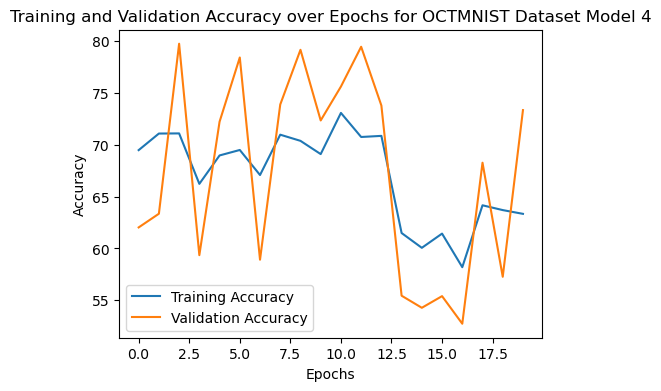

In [68]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_acc_four, label='Training Accuracy')
plt.plot(octmnist_val_acc_four, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs for OCTMNIST Dataset Model 4')
plt.legend()
plt.show()

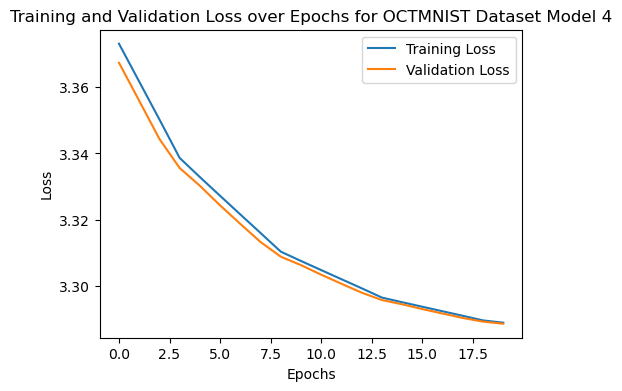

In [69]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(octmnist_train_loss_four, label='Training Loss')
plt.plot(octmnist_val_loss_four, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for OCTMNIST Dataset Model 4')
plt.legend()
plt.show()

In [128]:
y_pred_test = np.concatenate([p.cpu().numpy() for p in octmnist_y_pred_test_four])
y_labels_test = np.concatenate([l.cpu().numpy() for l in octmnist_y_labels_test_four])
matrix = confusion_matrix(y_labels_test, y_pred_test)
print(f'Confusion Matrix of OCTMNSIT2D Model 4 : {matrix}')

Confusion Matrix of OCTMNSIT2D Model 4 : [[25050 60120 10020  5010]
 [ 7555 18132  3022  1511]
 [ 5740 13776  2296  1148]
 [34765 83436 13906  6953]]


<Axes: >

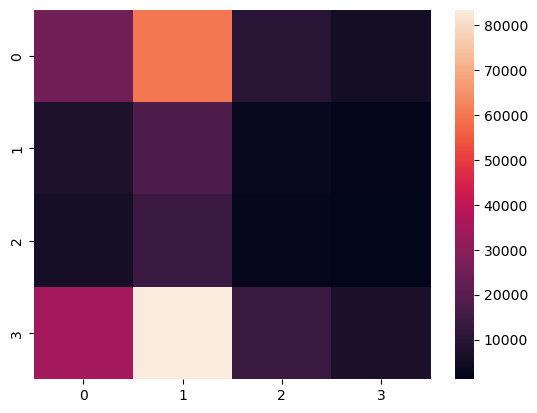

In [129]:
sns.heatmap(matrix)

# FLASK Deployement
Deploy a model you defined in Part 1 or 3 on the server using any tools/methods.

In [ ]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict',methods=['POST'])
def predict():
    input_data = request.json['input']
    input_tensor = torch.tensor(input_data, dtype=torch.float)
    output_tensor = model(input_tensor,dtype=torch.float) #octmnist_model->bestmodel
    model.load_state_dict(torch.load('your_model.pth'))
    model.eval()
    output_array = output_tensor.detach().numpy()
    probabilities = F.softmax(torch.tensor(output_array)).detach().numpy()
    response = {'class':int(torch.argmax(output_tensor)),'probabilities':probabilities.tolist()}
    return jsonify(response)

if __name__ == "__main__":
    app.run(port=5000)
    

**References**
1. https://medmnist.com/
2. https://github.com/MedMNIST/MedMNIST
3. https://zenodo.org/records/6496656
4. Part 3 is based on the CSE 574 Machine Learning Assignment 0,1,2,3 and Quiz 5submission by Radhika Singh[rsingh57, 50537855] and CSE 676 Deep Learning Assignment 0 - Part1 Submission by Radhika Singh[rsingh57@buffalo.edu]
5. https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb
6. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
7. https://www.turing.com/kb/convert-categorical-data-in-pandas-and-scikit-learn#method-1:-label-encoding
8. https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/
9. https://colab.research.google.com/drive/1xEeGMdHMVdHapshhfiw9srdw3RyVehbP
10. https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
11. https://www.w3schools.com/python/python_ml_knn.asp
12. https://www.w3schools.com/python/python_ml_decision_tree.asp
13. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
14. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
15. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
16. https://www.datacamp.com/tutorial/decision-tree-classification-python
17. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
18. https://www.learnpytorch.io/02_pytorch_classification/
19. https://www.cs.toronto.edu/~lczhang/321/tut/tut04.pdf
20. https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
21. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
22. https://saturncloud.io/blog/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor/
23. https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
24. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
25. https://pytorch.org/tutorials/beginner/saving_loading_models.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
26. https://pytorch.org/vision/stable/transforms.html
27. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
28. https://pytorch.org/torcheval/stable/generated/torcheval.metrics.MulticlassAccuracy.html
29. https://pytorch.org/docs/stable/generated/torch.cat.html
30. https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
31. https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/
32. https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
33. https://stackoverflow.com/questions/56106332/how-can-i-implement-early-stopping-and-reduce-learning-rate-on-plateau-in-tensor
34. https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md
35. https://lightning.ai/docs/torchmetrics/stable/classification/confusion_matrix.html
36. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
37. https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html
38. https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
39. 
40. 
41. 
42. 
43. 
44. 
45. 
46. 
47. 
48. 
49. 
50. 